In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from typing import Tuple
from scipy.stats import mode
from scipy.spatial.distance import pdist
from sklearn.metrics import confusion_matrix


csv_path = "diabetes.csv"

In [2]:
def load_csv(csv_path:str):
    df = pd.read_csv(csv_path)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    x,y =  df.iloc[:, :-1],df.iloc[:,-1]
    return x,y

In [3]:
x,y = load_csv(csv_path)
x,y

(     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0              6       98             58             33      190  34.0   
 1              2      112             75             32        0  35.7   
 2              2      108             64              0        0  30.8   
 3              8      107             80              0        0  24.6   
 4              7      136             90              0        0  29.9   
 ..           ...      ...            ...            ...      ...   ...   
 763            5      139             64             35      140  28.6   
 764            1       96            122              0        0  22.4   
 765           10      101             86             37        0  45.6   
 766            0      141              0              0        0  42.4   
 767            0      125             96              0        0  22.5   
 
      DiabetesPedigreeFunction  Age  
 0                       0.430   43  
 1                    

In [4]:
np.mean(x,axis=0),np.var(x,axis=0)

(Pregnancies                   3.845052
 Glucose                     120.894531
 BloodPressure                69.105469
 SkinThickness                20.536458
 Insulin                      79.799479
 BMI                          31.992578
 DiabetesPedigreeFunction      0.471876
 Age                          33.240885
 dtype: float64,
 Pregnancies                    11.339272
 Glucose                      1020.917262
 BloodPressure                 374.159449
 SkinThickness                 254.141900
 Insulin                     13263.886875
 BMI                            62.079046
 DiabetesPedigreeFunction        0.109636
 Age                           138.122964
 dtype: float64)

In [67]:
np.nanmean(x,axis=0),np.nanvar(x,axis=0)

(array([  3.84505208, 120.89453125,  69.10546875,  20.53645833,
         79.79947917,  31.99257812,   0.4718763 ,  33.24088542]),
 array([1.13392724e+01, 1.02091726e+03, 3.74159449e+02, 2.54141900e+02,
        1.32638869e+04, 6.20790465e+01, 1.09635697e-01, 1.38122964e+02]))

In [68]:
x[np.isnan(x)] = 3.5
x.shape

(768, 8)

In [69]:
np.mean(x,axis=0),np.var(x,axis=0)

(Pregnancies                   3.845052
 Glucose                     120.894531
 BloodPressure                69.105469
 SkinThickness                20.536458
 Insulin                      79.799479
 BMI                          31.992578
 DiabetesPedigreeFunction      0.471876
 Age                          33.240885
 dtype: float64,
 Pregnancies                    11.339272
 Glucose                      1020.917262
 BloodPressure                 374.159449
 SkinThickness                 254.141900
 Insulin                     13263.886875
 BMI                            62.079046
 DiabetesPedigreeFunction        0.109636
 Age                           138.122964
 dtype: float64)

In [70]:
(x > 13.0).sum(), (x < 0.0).sum()

(Pregnancies                   4
 Glucose                     763
 BloodPressure               733
 SkinThickness               508
 Insulin                     394
 BMI                         757
 DiabetesPedigreeFunction      0
 Age                         768
 dtype: int64,
 Pregnancies                 0
 Glucose                     0
 BloodPressure               0
 SkinThickness               0
 Insulin                     0
 BMI                         0
 DiabetesPedigreeFunction    0
 Age                         0
 dtype: int64)

In [ ]:
x[np.where(np.logical_or(x > 13.0,x < 0.0))]

In [6]:
less_than = np.where(x < 0.0)
higher_than = np.where(x > 13.0)
less_than,higher_than

((array([], dtype=int64), array([], dtype=int64)),
 (array([  0,   0,   0, ..., 767, 767, 767], dtype=int64),
  array([1, 2, 3, ..., 2, 5, 7], dtype=int64)))

In [ ]:
y = np.delete(y,np.where(x < 0.0)[0],axis=0)
y = np.delete(y,np.where(x > 13.0)[0],axis=0)
x = np.delete(x,np.where(x < 0.0)[0],axis=0)
x = np.delete(x,np.where(x > 13.0)[0],axis=0)
x.shape,y.shape

Train test split
try optim

In [16]:
def train_test_split(features:pd.DataFrame,
                     labels:pd.Series,
                     test_split_ratio:float) -> None:
        
    test_size = int(len(features) * test_split_ratio)
    train_size = len(features) - test_size
    assert len(features) == test_size + train_size, "Size mismatch!"

    x_train,y_train = features.iloc[:train_size,:],labels.iloc[:train_size]
    x_test,y_test = features.iloc[train_size:train_size+test_size,:], labels.iloc[train_size:train_size + test_size]
    return (x_train.reset_index(drop=True),y_train.reset_index(drop=True),x_test.reset_index(drop=True),y_test.reset_index(drop=True))

In [17]:
x_train, y_train, x_test, y_test = train_test_split(x, y, 0.2)

Distance

In [18]:
def euclidean(points: pd.DataFrame, element_of_x: pd.Series) -> pd.Series:
    return pd.np.sqrt(((points - element_of_x)**2).sum(axis=1))

In [19]:
euclidean(x_train, x_test.iloc[0])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3204\291728741.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  return pd.np.sqrt(((points - element_of_x)**2).sum(axis=1))


0      195.794581
1       52.922332
2       42.098231
3       33.526730
4       62.845547
          ...    
610     67.537045
611     38.977620
612     43.646649
613     57.508695
614     93.675214
Length: 615, dtype: float64

Predict func

In [20]:
def predict(x_train:pd.DataFrame,y_train:pd.DataFrame,x_test:pd.DataFrame,k:int) -> pd.DataFrame:
    labels_pred = []
    for idx, x_test_element in x_test.iterrows():
        distances = euclidean(x_train,x_test_element)
        distances = pd.DataFrame({'distances': distances, 'labels': y_train})
        distances.sort_values(by='distances', inplace=True)
        label_pred = mode(distances.iloc[:k,1],axis=0).mode[0]
        labels_pred.append(label_pred)
    return pd.Series(labels_pred)

In [22]:
y_preds = predict(x_train, y_train, x_test, 2)
#y_test.reset_index(drop=True)
y_test

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3204\291728741.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  return pd.np.sqrt(((points - element_of_x)**2).sum(axis=1))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3204\584228027.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label_pred = mode(distances.iloc[:k,1],axis=0).mode[0]


0      0
1      0
2      0
3      1
4      0
      ..
148    0
149    0
150    1
151    1
152    0
Name: Outcome, Length: 153, dtype: int64

Metrics

In [24]:
def accuracy(y_test:pd.Series,y_preds:pd.Series) -> float:
    true_positive = (y_test == y_preds).sum()
    return true_positive / len(y_test) * 100

In [25]:
accuracy(y_test, y_preds)

67.97385620915033

In [27]:
def plot_confusion_matrix(y_test:np.ndarray,y_preds:np.ndarray):
        return confusion_matrix(y_test,y_preds)

<AxesSubplot:>

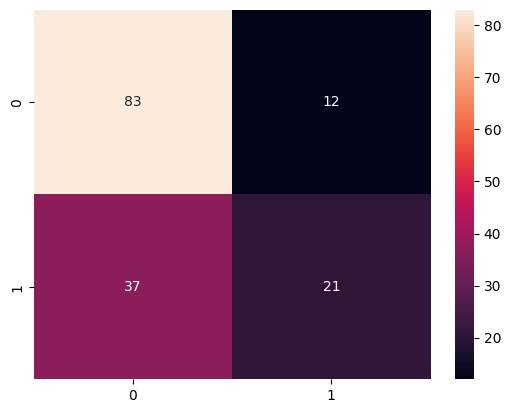

In [28]:
matrix = plot_confusion_matrix(y_test, y_preds)
sns.heatmap(matrix,annot=True) 